# Notebook des essais de différents modèle de clustering

# Sommaire:


**Objectif**

**<a href="#C1">I) Importation des librairies</a>**

**<a href="#C2">II) Création des dataframes principaux (commandes et clients)</a>**
&nbsp;

**<a href="#C3">III) Comparaison des modèles de clustering sur un échantillon</a>**
-   A) Création de l'échantillon
-   B) Modèle 1 : Kmeans
-   C) Modèle 2 : Classification Ascendante Hiérarchique
-   D) Modèle 3 : DBSCAN
&nbsp;

**<a href="#C4">IV) Stabilité des différents modèles</a>**
-   A) Création des pipelines de modélisation
-   B) Création du dataframe à T0
-   C) Algorithme de calcul de la stabilité des clusters
&nbsp;

**<a href="#C5">V) Clustering final sur les données totales </a>**
-   A) Détermination du meilleur nombre de clusters
-   B) Stabilité des clusters
-   C) Caractéristation des clusters
-   D) Visualisation par ACP
-   E) Visualisation par t-SNE
&nbsp;


***

# **Objectif**

L'objectif de ce notebook est de trouver le meilleur modèle de segmentation des données. \
Pour cela, trois algorithmes de segmentation seront analysés et optimisés: 
- le modèle kmeans 
- le modèle de Classification Ascendante Hiérarchique 
- le modèle DBSCAN
&nbsp;

Afin de comparer ces trois modèles, la stabilité des trois modèles sera calculée dans un interval de temps de 26 semaines.\
Pour ces calculs, les données doivent répondre à deux propriétés : 
-   Chaque client doit être présent du début à la fin de l’expérience de modélisation (premier achat > 26 semaines)
-   Le jeu de donnée doit évoluer (nb commande final > 1)

Un échantillon correspondant à ces critère sera d'abord créé. 

Les différentes étapes sont : 
- Récupération de l'index des clients présents tout au long de l'analyse (même clients du début à la fin) qui ont 2 commandes ou plus. 
- Création d'un dataframe 'client' avec les commandes au temps Tn
- Entraîenement des modèles sur la semaine Tn et prédiction des clusters Tn
- Calcul de la stabilité (Adjusted Rand Index : ARI) entre les cluster du temps Tn et Tn+1

Après la découverte du meilleur modèle (plus stable, efficace et rapide), celui-ci sera appliqués et ré-optimisé sur les données totales. \
Les clusters qui en découlent seront par la suite caractérisés.

# <a name="C1"> I) Importation des librairies</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score

# <a name="C2"> II) Création des dataframes principaux (commandes et clients)</a>

In [2]:
# Importation des données
olist_customers_dataset = pd.read_csv('data\olist_customers_dataset.csv', usecols=[
                                      'customer_id', 'customer_unique_id', 'customer_state'])
olist_orders_dataset = pd.read_csv('data\olist_orders_dataset.csv', usecols=[
                                   'order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
                                   'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
olist_order_items_dataset = pd.read_csv('data\olist_order_items_dataset.csv', usecols=[
                                        'order_id', 'price', 'product_id', 'order_item_id'])
olist_order_reviews_dataset = pd.read_csv(
    'data\olist_order_reviews_dataset.csv', usecols=['order_id', 'review_score'])
olist_order_payments_dataset = pd.read_csv(
    'data\olist_order_payments_dataset.csv', usecols=['order_id', 'payment_type'])


# Jointure des données
dfs_orders = [olist_orders_dataset,
              olist_order_items_dataset, olist_order_reviews_dataset]
df_full = reduce(lambda left, right: pd.merge(
    left, right, on='order_id', how='outer'), dfs_orders)
df_full = pd.merge(df_full, olist_customers_dataset,
                   on='customer_id', how='outer')

# Filtre des commandes annulées
df_full = df_full[(df_full.order_status != 'canceled') &
                  (df_full.order_status != 'unavailable')]

# Mise au format Datetime des colonnes de dates
lst_var_date = ['order_approved_at',
                'order_delivered_customer_date', 'order_estimated_delivery_date']

for var in lst_var_date:
    df_full[var] = pd.to_datetime(
        df_full[var], errors='coerce').dt.normalize()

# Création d'une colonne temps de livraison
df_full['Delivery_Time'] = (
    df_full['order_delivered_customer_date'] - df_full['order_approved_at']).dt.days

# Pour certaines valeurs, le temps de livraison est négatif
df_full['Delivery_Time'] = np.where(
    df_full['Delivery_Time'] < 0, 0, df_full['Delivery_Time'])

In [3]:
# Création du jeu de données par clients et par commande

df_Customers_order = df_full[['Delivery_Time',
                              'customer_unique_id',
                              'price',
                              'product_id',
                              'review_score',
                              'order_id',
                              'order_approved_at',
                              'customer_state'
                              ]]\
    .groupby(['customer_unique_id', 'order_id'])\
    .agg({'Delivery_Time': 'mean',
          'review_score': 'mean',
          'price': 'mean',
          'order_approved_at': 'max',
          'customer_state': 'max',
          'product_id': 'count'})

df_Customers_order['Sum_tot'] = df_full[['customer_unique_id', 'order_id', 'price']].groupby(
    ['customer_unique_id', 'order_id']).agg('sum')
df_Customers_order = df_Customers_order.reset_index()

In [4]:
# Création du jeu de données par clients
df_Customers = df_Customers_order.groupby('customer_unique_id')\
    .agg({'Delivery_Time': 'mean',
          'review_score': 'mean',
          'order_approved_at': 'min',
          'Sum_tot': 'sum'}).round(2)

df_Customers.columns = ['mean_delivery_time',
                        'mean_review_score',
                        'first_order',
                        'total_expanse']

# Date de la dernière commande
df_Customers['last_order'] = df_Customers_order.groupby(
    'customer_unique_id').agg({'order_approved_at': 'max'})

# Récence (date du jour - date du dernier achat)
df_Customers['recency'] = (
    df_Customers["last_order"].max() - df_Customers['last_order']).dt.days

# nombre de commande totale
df_Customers['nb_order'] = df_Customers_order.groupby(
    'customer_unique_id').agg({'order_id': 'count'})

# nombre moyen d'article par panier
df_Customers['mean_nb_item'] = df_Customers_order.groupby(
    'customer_unique_id').agg({'product_id': 'mean'}).round(2)

# Montant de la dernière commande
price_last_order = df_full.sort_values('order_approved_at').groupby(
    'customer_unique_id')['price'].agg(['last']).reset_index()

df_Customers = df_Customers.merge(
    price_last_order, on='customer_unique_id', how='left')
df_Customers.rename(columns={'last': 'last_order_price'}, inplace=True)


df_Customers = df_Customers.set_index('customer_unique_id')

In [5]:
# Création d'un pipeline de pre-processing

features = ['mean_review_score',
            'nb_order',
            'mean_nb_item']


log_features = ['mean_delivery_time',
                'total_expanse',
                'recency']

features_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)

logfeatures_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("logTransformation", FunctionTransformer(
               lambda value: np.log1p(value))),
           ("scaler", StandardScaler())]
)


preprocessor = ColumnTransformer(
    remainder='drop',
    transformers=[
        ("features", features_transformer, features),
        ("log_features", logfeatures_transformer, log_features),
    ]
)

# <a name="C3"> III) Comparaison des modèles de clustering sur un échantillon</a>

### A) Création de l'échantillon

In [6]:
df_cust_more_order = df_Customers[df_Customers["nb_order"] > 1].copy()
X_scaled_sample = pd.DataFrame(preprocessor.fit_transform(
    df_cust_more_order), columns=[*features+log_features])

### B) Modèle 1 : Kmeans

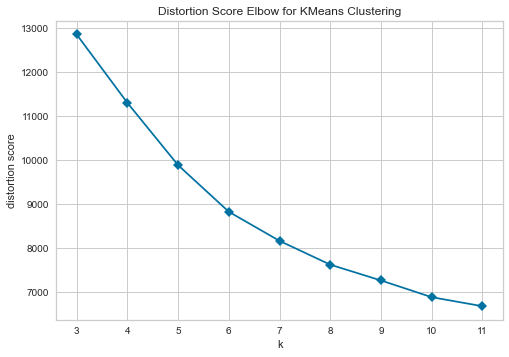

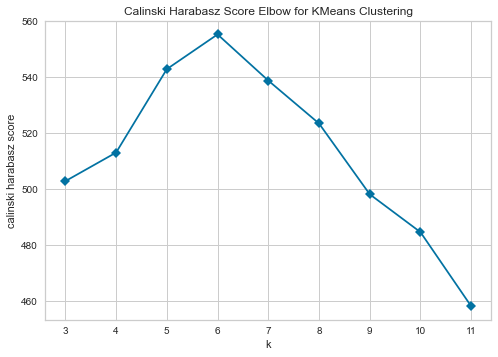

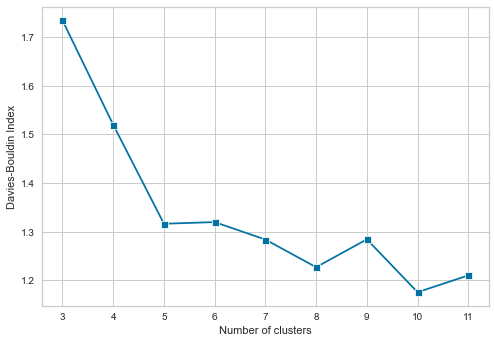

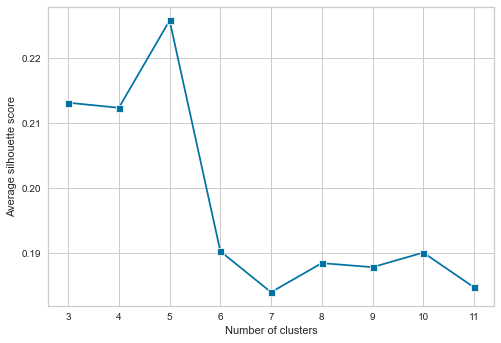

In [7]:
model = KMeans(random_state=0)

db_index = []
sil = []


visualizer = KElbowVisualizer(
    model, k=(3, 12), timings=False, locate_elbow=False)

visualizer.fit(X_scaled_sample)    # Fit the data to the visualizer
#plt.figure(figsize=(10, 10))

visualizer.show()

visualizer = KElbowVisualizer(
    model, k=(3, 12), metric='calinski_harabasz', timings=False, locate_elbow=False)

visualizer.fit(X_scaled_sample)    # Fit the data to the visualizer
visualizer.show()

for k in range(3, 12):
    kmeans = KMeans(n_clusters=k,  random_state=0)
    kmeans.fit(X_scaled_sample)
    labels = kmeans.predict(X_scaled_sample)
    sil_T = silhouette_score(X_scaled_sample, labels, sample_size=5000)
    sil.append(sil_T)
    db_index_t = davies_bouldin_score(X_scaled_sample, labels)
    db_index.append(db_index_t)


sns.lineplot(x=range(3, 12), y=db_index,
             marker="s", dashes=False)
plt.xticks(range(3, 12))
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Bouldin Index")
plt.show()

sns.lineplot(x=range(3, 12), y=sil,
             marker="s", dashes=False)
plt.xticks(range(3, 12))
plt.xlabel("Number of clusters")
plt.ylabel("Average silhouette score")
plt.show()

### C) Modèle 2 : Classification Ascendante Hiérarchique

In [8]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

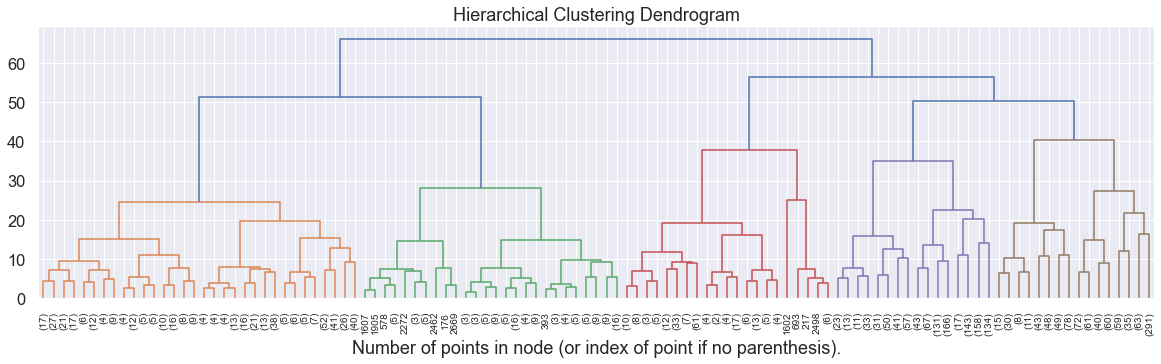

In [9]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(compute_distances=True)
label = model.fit_predict(X_scaled_sample)
# X_scaled_sample['label']=label


sns.set(font_scale=1.5)
#plt.figure(figsize=(20, 5))
fig, ax = plt.subplots(figsize=(20, 5))
plot_dendrogram(model, truncate_mode="level", p=6)
ax.xaxis.set_tick_params(labelsize=10)

plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [10]:
sil_score = silhouette_score(X_scaled_sample, labels, sample_size=2000)
db_index = davies_bouldin_score(X_scaled_sample, labels)
CalHar_score = calinski_harabasz_score(X_scaled_sample, labels)


print("silhouette score : %f" % sil_score)
print("Davies Bouldin score : %f" % db_index)
print("Calinski Harabasz score : %f" % CalHar_score)

silhouette score : 0.185072
Davies Bouldin score : 1.210173
Calinski Harabasz score : 458.243570


### D) Modèle 3 : DBSCAN

Text(0, 0.5, 'Distances des 7-NN')

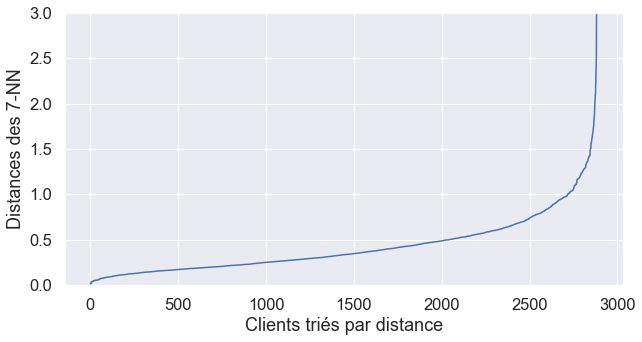

In [11]:
from sklearn.neighbors import NearestNeighbors


neigh = NearestNeighbors(n_neighbors=7)
nbrs = neigh.fit(X_scaled_sample)
distances, indices = nbrs.kneighbors(X_scaled_sample)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.ylim(0, 3)
plt.xlabel("Clients triés par distance")
plt.ylabel("Distances des 7-NN")

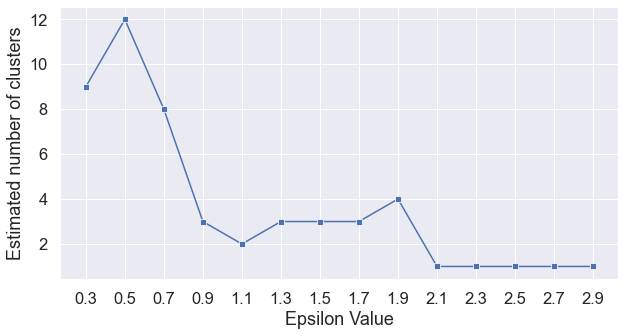

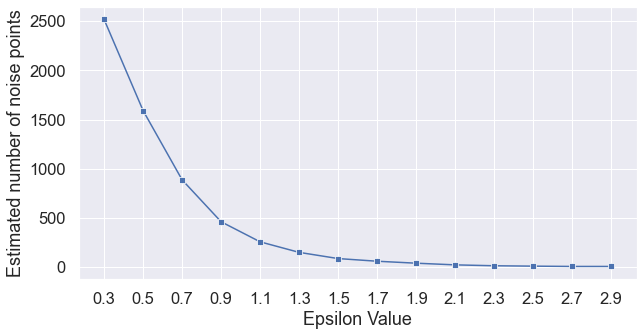

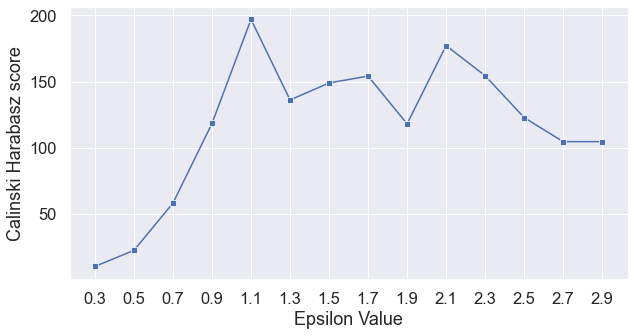

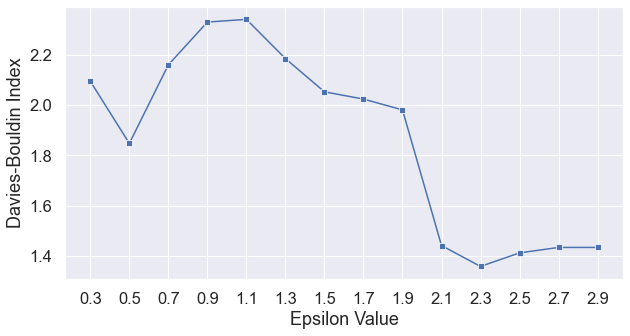

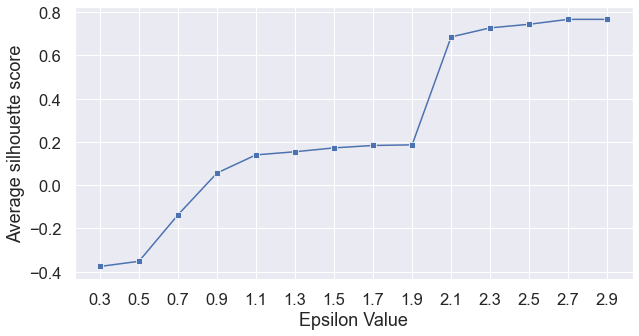

In [12]:
from sklearn.cluster import DBSCAN

CalHar_index = []
db_index = []
sil = []
n_clusters_ = []
n_noise_ = []

for i in np.arange(0.3, 3, 0.2):
    Birch_model = DBSCAN(eps=i, min_samples=7)
    labels = Birch_model.fit_predict(X_scaled_sample)

    n_clusters_t = len(set(labels)) - (1 if -1 in labels else 0)
    n_clusters_.append(n_clusters_t)

    n_noise_t = list(labels).count(-1)
    n_noise_.append(n_noise_t)

    sil_T = silhouette_score(X_scaled_sample, labels, sample_size=5000)
    sil.append(sil_T)

    db_index_t = davies_bouldin_score(X_scaled_sample, labels)
    db_index.append(db_index_t)

    CalHar_index_t = calinski_harabasz_score(X_scaled_sample, labels)
    CalHar_index.append(CalHar_index_t)


plt.figure(figsize=(10, 5))

sns.lineplot(x=np.arange(0.3, 3, 0.2), y=n_clusters_,
             marker="s", dashes=False)
plt.xticks(np.arange(0.3, 3, 0.2))
plt.xlabel("Epsilon Value")
plt.ylabel("Estimated number of clusters")
plt.show()

plt.figure(figsize=(10, 5))

sns.lineplot(x=np.arange(0.3, 3, 0.2), y=n_noise_,
             marker="s", dashes=False)
plt.xticks(np.arange(0.3, 3, 0.2))
plt.xlabel("Epsilon Value")
plt.ylabel("Estimated number of noise points")
plt.show()


plt.figure(figsize=(10, 5))

sns.lineplot(x=np.arange(0.3, 3, 0.2), y=CalHar_index,
             marker="s", dashes=False)
plt.xticks(np.arange(0.3, 3, 0.2))
plt.xlabel("Epsilon Value")
plt.ylabel("Calinski Harabasz score")
plt.show()


plt.figure(figsize=(10, 5))

sns.lineplot(x=np.arange(0.3, 3, 0.2), y=db_index,
             marker="s", dashes=False)
plt.xticks(np.arange(0.3, 3, 0.2))
plt.xlabel("Epsilon Value")
plt.ylabel("Davies-Bouldin Index")
plt.show()

plt.figure(figsize=(10, 5))

sns.lineplot(x=np.arange(0.3, 3, 0.2), y=sil,
             marker="s", dashes=False)
plt.xticks(np.arange(0.3, 3, 0.2))
plt.xlabel("Epsilon Value")
plt.ylabel("Average silhouette score")
plt.show()

# <a name="C4"> IV) Stabilité des différents modèles</a>

### A) Création des pipelines de modélisation

In [14]:
Kmean_pipeline = Pipeline(steps=[('pre_processing', preprocessor),
                                 ('kmeans', KMeans(random_state=0, n_clusters=6))
                                 ])
CAH_pipeline = Pipeline(steps=[('pre_processing', preprocessor),
                               ('CAH', AgglomerativeClustering(n_clusters=5))
                               ])
DBSCAN_pipeline = Pipeline(steps=[('pre_processing', preprocessor),
                                  ('dbscan', DBSCAN(eps=1.3, min_samples=7))
                                  ])

### B) Création du dataframe à t0

In [15]:
# récupération de leur index (customer_unique_id)
Index_df = df_cust_more_order[df_cust_more_order['first_order'] <
                              df_cust_more_order['last_order'].max() - pd.DateOffset(weeks=26)].index

# Création du df pour le calcul de l'ARI
df_ARI_order = df_Customers_order.loc[df_Customers_order['customer_unique_id'].isin(
    Index_df)].copy()

In [16]:
# Dataframe at t0, 26 weeks ~5 months :
time_export = (df_cust_more_order['last_order'].max(
) - pd.DateOffset(weeks=26)).strftime("%Y-%m-%d")

df_temp_order = df_ARI_order[df_ARI_order['order_approved_at'] < time_export]


df_temp_customer = df_temp_order.groupby('customer_unique_id')\
    .agg({'Delivery_Time': 'mean',
          'review_score': 'mean',
          'order_approved_at': 'min',
          'Sum_tot': 'sum'}).round(2)

df_temp_customer.columns = ['mean_delivery_time',
                            'mean_review_score',
                            'first_order',
                            'total_expanse']

# Date de la dernière commande
df_temp_customer['last_order'] = df_temp_order.groupby(
    'customer_unique_id').agg({'order_approved_at': 'max'})

# Recency : (date du jour - date du dernier achat)
df_temp_customer['recency'] = (
    df_temp_customer["last_order"].max() - df_temp_customer['last_order']).dt.days

# Nb_order : nombre de commande totale
df_temp_customer['nb_order'] = df_temp_order.groupby(
    'customer_unique_id').agg({'order_id': 'count'})

# Mean_nb_item : nombre moyen d'article par panier
df_temp_customer['mean_nb_item'] = df_temp_order.groupby(
    'customer_unique_id').agg({'product_id': 'mean'}).round(2)


#df_temp_customer = df_temp_customer.set_index('customer_unique_id')
df_t0 = df_temp_customer

### C) Algorithme de calcul de la stabilité des clusters

In [17]:
Kmeans_Cluster_Stability = pd.DataFrame(
    Kmean_pipeline.fit_predict(df_t0), columns=[time_export])
CAH_Cluster_Stability = pd.DataFrame(
    CAH_pipeline.fit_predict(df_t0), columns=[time_export])
DBSCAN_Cluster_Stability = pd.DataFrame(
    DBSCAN_pipeline.fit_predict(df_t0), columns=[time_export])

In [18]:
for week in range(25, -1, -1):
    # sauvegarde du temps de l'export :
    time_export = (df_cust_more_order['last_order'].max(
    ) - pd.DateOffset(weeks=week)).strftime("%Y-%m-%d")

    df_temp_order = df_ARI_order[df_ARI_order['order_approved_at'] < time_export]

    df_temp_customer = df_temp_order.groupby('customer_unique_id')\
        .agg({'Delivery_Time': 'mean',
              'review_score': 'mean',
              'order_approved_at': 'min',
              'Sum_tot': 'sum'}).round(2)

    df_temp_customer.columns = ['mean_delivery_time',
                                'mean_review_score',
                                'first_order',
                                'total_expanse']

    # Date de la dernière commande
    df_temp_customer['last_order'] = df_temp_order.groupby(
        'customer_unique_id').agg({'order_approved_at': 'max'})

    # Recency : (date du jour - date du dernier achat)
    df_temp_customer['recency'] = (
        df_temp_customer["last_order"].max() - df_temp_customer['last_order']).dt.days

    # Nb_order : nombre de commande totale
    df_temp_customer['nb_order'] = df_temp_order.groupby(
        'customer_unique_id').agg({'order_id': 'count'})

    # Mean_nb_item : nombre moyen d'article par panier
    df_temp_customer['mean_nb_item'] = df_temp_order.groupby(
        'customer_unique_id').agg({'product_id': 'mean'}).round(2)

    # Entrainement du modèle sur le df au temps X et Prédiction des clusters : stablitié des cluster
    Kmeans_Cluster_Stability[time_export] = Kmean_pipeline.fit_predict(
        df_temp_customer)
    CAH_Cluster_Stability[time_export] = CAH_pipeline.fit_predict(
        df_temp_customer)
    DBSCAN_Cluster_Stability[time_export] = DBSCAN_pipeline.fit_predict(
        df_temp_customer)

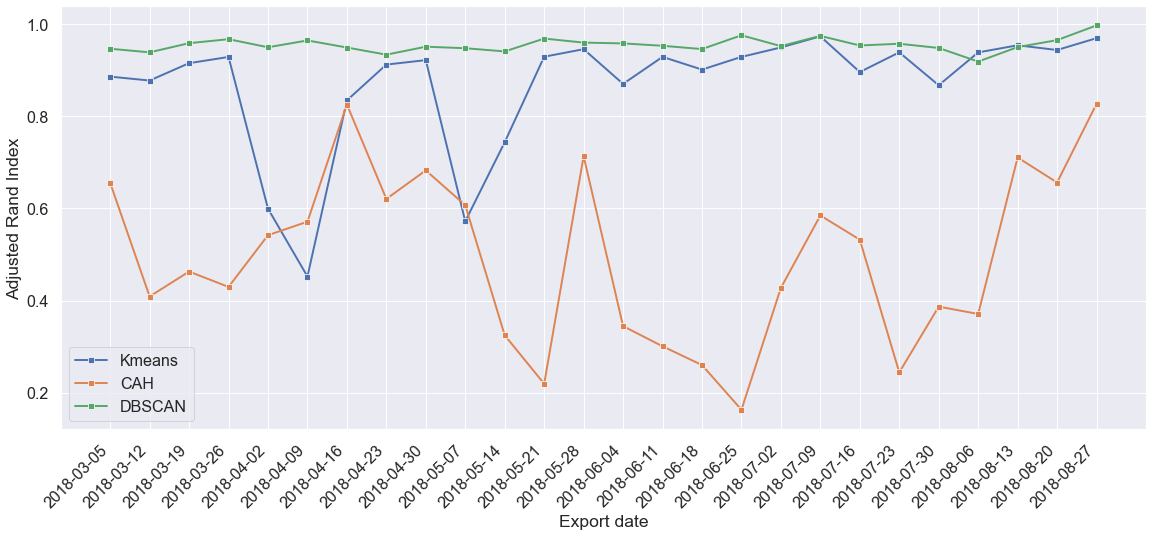

In [19]:
ARI_CAH = []
ARI_kmeans = []
ARI_dbscan = []


for col in range(0, 26):
    tempARI = adjusted_rand_score(
        CAH_Cluster_Stability.iloc[:, col], CAH_Cluster_Stability.iloc[:, col+1])
    ARI_CAH.append(tempARI)

    tempkmeans = adjusted_rand_score(
        Kmeans_Cluster_Stability.iloc[:, col], Kmeans_Cluster_Stability.iloc[:, col+1])
    ARI_kmeans.append(tempkmeans)

    tempdbscan = adjusted_rand_score(
        DBSCAN_Cluster_Stability.iloc[:, col], DBSCAN_Cluster_Stability.iloc[:, col+1])
    ARI_dbscan.append(tempdbscan)


ARI_kmeans_stability = pd.DataFrame(ARI_kmeans, columns=["ARI"])
ARI_kmeans_stability['date'] = list(Kmeans_Cluster_Stability.columns)[:-1]

ARI_CAH_stability = pd.DataFrame(ARI_CAH, columns=["ARI"])
ARI_CAH_stability['date'] = list(CAH_Cluster_Stability.columns)[:-1]

ARI_dbscan_stability = pd.DataFrame(ARI_dbscan, columns=["ARI"])
ARI_dbscan_stability['date'] = list(DBSCAN_Cluster_Stability.columns)[:-1]

plt.figure(figsize=(20, 8), dpi=70)

sns.lineplot(data=ARI_kmeans_stability, x='date', y='ARI',
             marker="s", linewidth=2, label='Kmeans')
sns.lineplot(data=ARI_CAH_stability, x='date', y='ARI',
             marker="s", linewidth=2, label='CAH')
sns.lineplot(data=ARI_dbscan_stability, x='date', y='ARI',
             marker="s", linewidth=2, label='DBSCAN')

plt.xlabel("Export date")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Adjusted Rand Index")
plt.legend(frameon=True)
plt.show()

In [20]:
print('ARI moyen des cluster de kmeans : ', round(
    ARI_kmeans_stability['ARI'].mean(), 2))
print('ARI moyen des cluster de DBSCAN :', round(
    ARI_dbscan_stability['ARI'].mean(), 2))
print("ARI moyen des cluster de l'CAH : ",
      round(ARI_CAH_stability['ARI'].mean(), 2))

ARI moyen des cluster de kmeans :  0.87
ARI moyen des cluster de DBSCAN : 0.96
ARI moyen des cluster de l'CAH :  0.5


# <a name="C5"> V) Clustering final sur les données totales </a>

### A) Détermination du meilleur nombre de clusters

In [21]:
X_scaled = pd.DataFrame(preprocessor.fit_transform(
    df_Customers), columns=[*features+log_features])

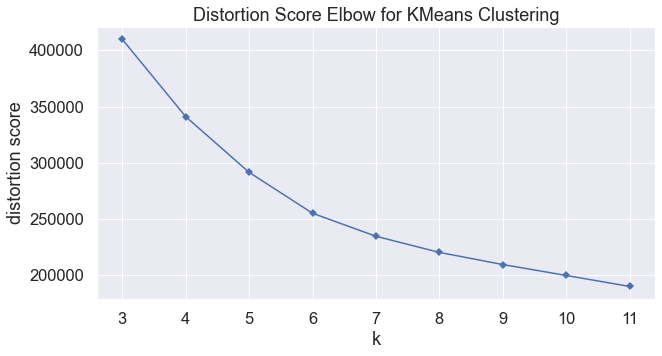

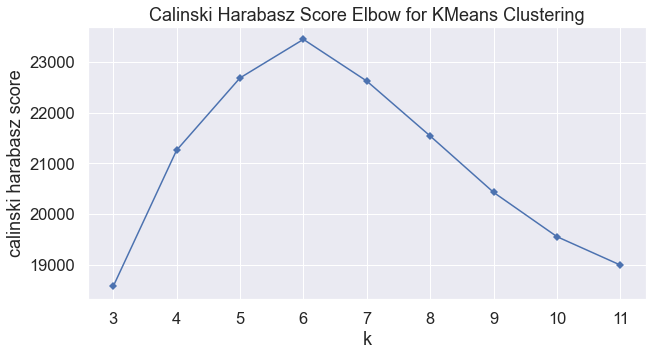

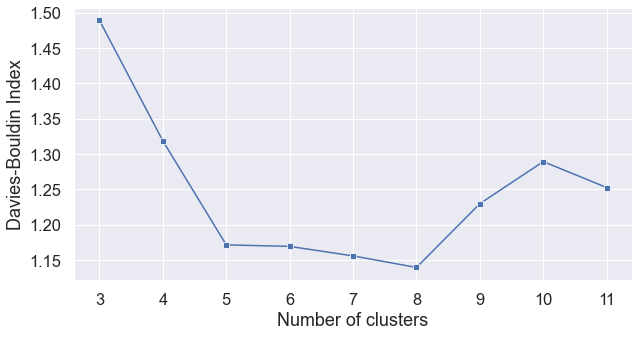

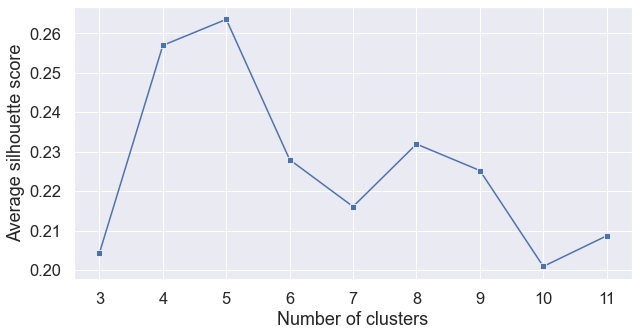

In [22]:
model = KMeans(random_state=0)

db_index = []
sil = []


visualizer = KElbowVisualizer(
    model, k=(3, 12), timings=False, locate_elbow=False)

plt.figure(figsize=(10, 5))

visualizer.fit(X_scaled)    # Fit the data to the visualizer
visualizer.show()

plt.figure(figsize=(10, 5))

visualizer = KElbowVisualizer(
    model, k=(3, 12), metric='calinski_harabasz', timings=False, locate_elbow=False)

visualizer.fit(X_scaled)    # Fit the data to the visualizer
visualizer.show()

for k in range(3, 12):
    kmeans = KMeans(n_clusters=k,  random_state=0)
    kmeans.fit(X_scaled)
    labels = kmeans.predict(X_scaled)
    sil_T = silhouette_score(X_scaled, labels, sample_size=5000)
    sil.append(sil_T)
    db_index_t = davies_bouldin_score(X_scaled, labels)
    db_index.append(db_index_t)

plt.figure(figsize=(10, 5))

sns.lineplot(x=range(3, 12), y=db_index,
             marker="s", dashes=False)
plt.xticks(range(3, 12))
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Bouldin Index")
plt.show()

plt.figure(figsize=(10, 5))

sns.lineplot(x=range(3, 12), y=sil,
             marker="s", dashes=False)
plt.xticks(range(3, 12))
plt.xlabel("Number of clusters")
plt.ylabel("Average silhouette score")
plt.show()

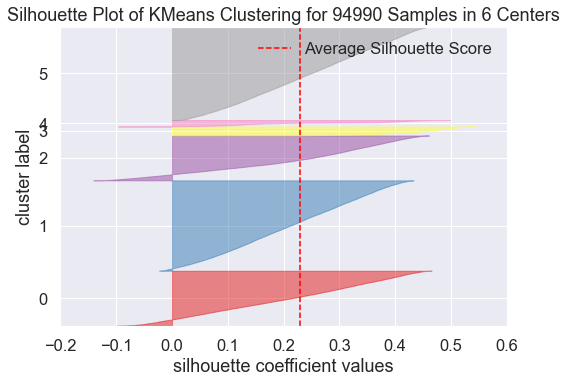

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 94990 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [23]:
model = KMeans(random_state=0, n_clusters=6)

visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_scaled)    # Fit the data to the visualizer
visualizer.show()

### B) Stabilité des clusters

In [24]:
# récupération de leur index (customer_unique_id)
Index_df_full = df_Customers[df_Customers['first_order'] <
                             df_Customers['last_order'].max() - pd.DateOffset(weeks=26)].index

# Création du df pour le calcul de l'ARI
df_ARI = df_Customers_order.loc[df_Customers_order['customer_unique_id'].isin(
    Index_df_full)].copy()

In [25]:
# Dataframe at t0, 26 weeks ~5 months :
time_export = (df_Customers['last_order'].max() -
               pd.DateOffset(weeks=26)).strftime("%Y-%m-%d")
df_temp_order = df_ARI[df_ARI['order_approved_at'] < time_export]


df_temp_customer = df_temp_order.groupby('customer_unique_id')\
    .agg({'Delivery_Time': 'mean',
          'review_score': 'mean',
          'order_approved_at': 'min',
          'Sum_tot': 'sum'}).round(2)

df_temp_customer.columns = ['mean_delivery_time',
                            'mean_review_score',
                            'first_order',
                            'total_expanse']

# Date de la dernière commande
df_temp_customer['last_order'] = df_temp_order.groupby(
    'customer_unique_id').agg({'order_approved_at': 'max'})

# Recency : (date du jour - date du dernier achat)
df_temp_customer['recency'] = (
    df_temp_customer["last_order"].max() - df_temp_customer['last_order']).dt.days

# Nb_order : nombre de commande totale
df_temp_customer['nb_order'] = df_temp_order.groupby(
    'customer_unique_id').agg({'order_id': 'count'})

# Mean_nb_item : nombre moyen d'article par panier
df_temp_customer['mean_nb_item'] = df_temp_order.groupby(
    'customer_unique_id').agg({'product_id': 'mean'}).round(2)


df_t0 = df_temp_customer

In [26]:
Kmean_pipeline = Pipeline(steps=[('pre_processing', preprocessor),
                                 ('kmeans', KMeans(random_state=0, n_clusters=6))
                                 ])


Kmeans_Cluster_Stability = pd.DataFrame(
    Kmean_pipeline.fit_predict(df_t0), columns=[time_export])

In [27]:
for week in range(25, -1, -1):
    # sauvegarde du temps de l'export :
    time_export = (df_Customers['last_order'].max(
    ) - pd.DateOffset(weeks=week)).strftime("%Y-%m-%d")

    # création du dataframe contenant toutes les ventes de la première vente à la dernièrevente - semaine :
    df_temp_order = df_ARI[df_ARI['order_approved_at'] < time_export]

    # création du dataframe regroupé par client
    df_temp_customer = df_temp_order.groupby('customer_unique_id')\
        .agg({'Delivery_Time': 'mean',
              'review_score': 'mean',
              'order_approved_at': 'min',
              'Sum_tot': 'sum'}).round(2)

    df_temp_customer.columns = ['mean_delivery_time',
                                'mean_review_score',
                                'first_order',
                                'total_expanse']

    # Date de la dernière commande
    df_temp_customer['last_order'] = df_temp_order.groupby(
        'customer_unique_id').agg({'order_approved_at': 'max'})

    # Recency : (date du jour - date du dernier achat)
    df_temp_customer['recency'] = (
        df_temp_customer["last_order"].max() - df_temp_customer['last_order']).dt.days

    # Nb_order : nombre de commande totale
    df_temp_customer['nb_order'] = df_temp_order.groupby(
        'customer_unique_id').agg({'order_id': 'count'})

    # Mean_nb_item : nombre moyen d'article par panier
    df_temp_customer['mean_nb_item'] = df_temp_order.groupby(
        'customer_unique_id').agg({'product_id': 'mean'}).round(2)

    # Entrainement du modèle sur le df au temps X et Prédiction des clusters : stablitié des cluster
    Kmeans_Cluster_Stability[time_export] = Kmean_pipeline.fit_predict(
        df_temp_customer)

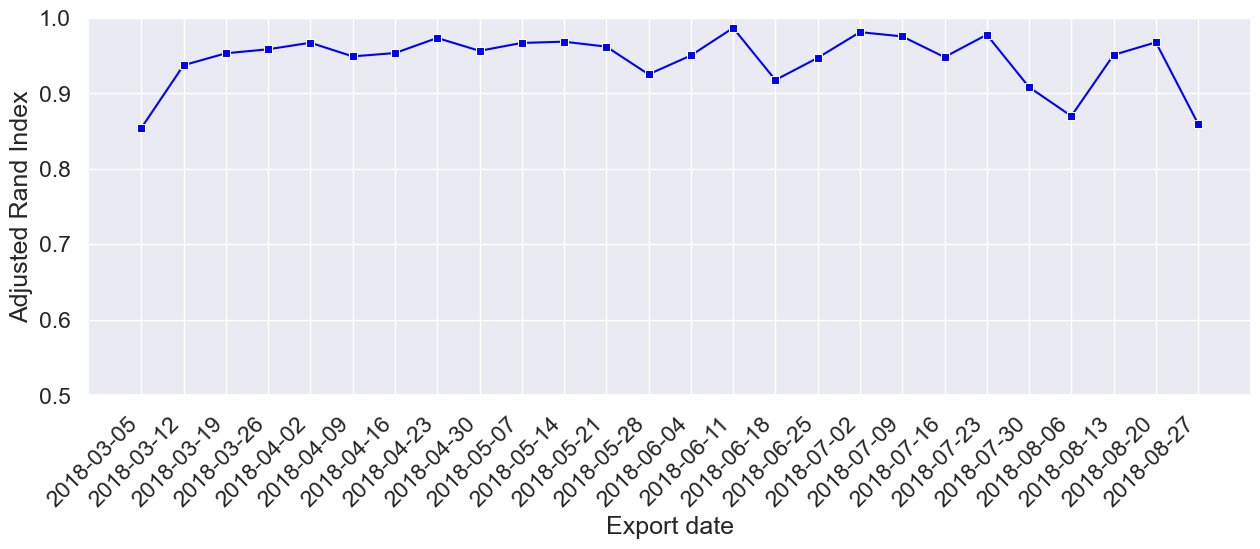

In [28]:
ARI_kmeans = []


for col in range(0, 26):
    temp = adjusted_rand_score(
        Kmeans_Cluster_Stability.iloc[:, col], Kmeans_Cluster_Stability.iloc[:, col+1])
    ARI_kmeans.append(temp)


ARI_kmeans_stability = pd.DataFrame(ARI_kmeans, columns=["ARI"])
ARI_kmeans_stability['date'] = list(Kmeans_Cluster_Stability.columns)[:-1]


plt.figure(figsize=(15, 5), dpi=100)

sns.lineplot(data=ARI_kmeans_stability, x='date',
             y='ARI', marker="s", color='blue')
plt.xlabel("Export date")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Adjusted Rand Index")
plt.ylim(0.5, 1)
plt.show()

In [29]:
round(ARI_kmeans_stability['ARI'].mean(), 4)

0.9445

### C) Caractérisation des clusters

In [30]:
model_kmeans = KMeans(random_state=0, n_clusters=6)
model_kmeans.fit(X_scaled)
df_Customers['Cluster_km'] = model_kmeans.predict(X_scaled)

In [31]:
centroids_km = pd.DataFrame(model_kmeans.cluster_centers_,
                            columns=X_scaled.columns).reset_index()

#### 1) Description des clusters

In [32]:
color_pal = sns.color_palette("colorblind", 6).as_hex()
colors = ','.join(color_pal)

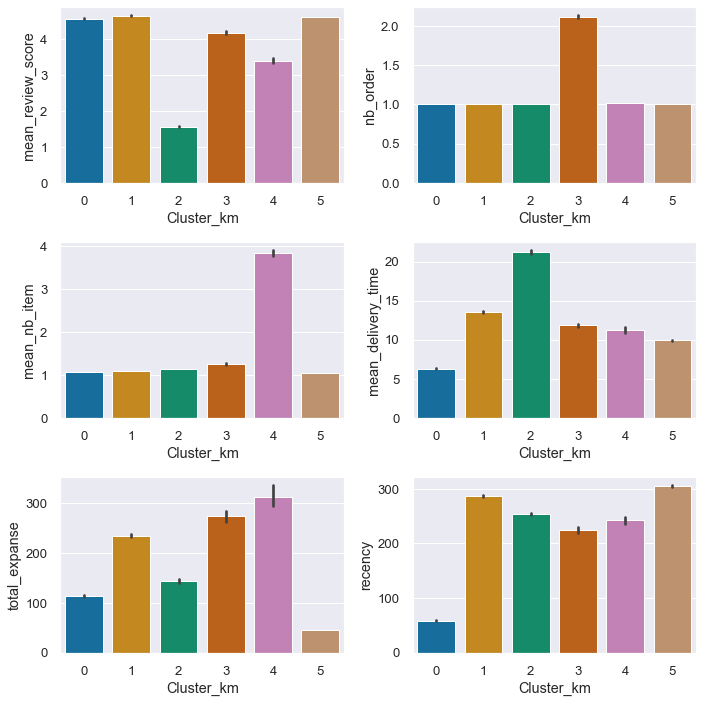

In [33]:
plt.figure(figsize=(10, 10))

sns.set(font_scale=1.2)
i = 0
for var in [*features+log_features]:
    ax = plt.subplot(3, 2, i+1)
    sns.barplot(data=df_Customers, x='Cluster_km', y=var, palette=color_pal)
    i += 1
plt.tight_layout()

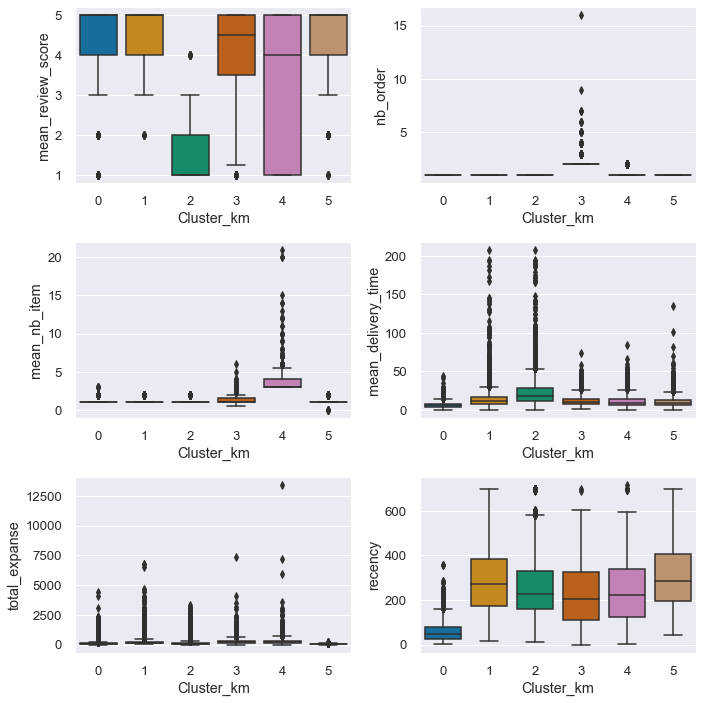

In [34]:
plt.figure(figsize=(10, 10))

sns.set(font_scale=1.2)
i = 0
for var in [*features+log_features]:
    ax = plt.subplot(3, 2, i+1)
    sns.boxplot(data=df_Customers, x='Cluster_km', y=var, palette=color_pal)
    i += 1
plt.tight_layout()

#### 2) Répartition des effectifs

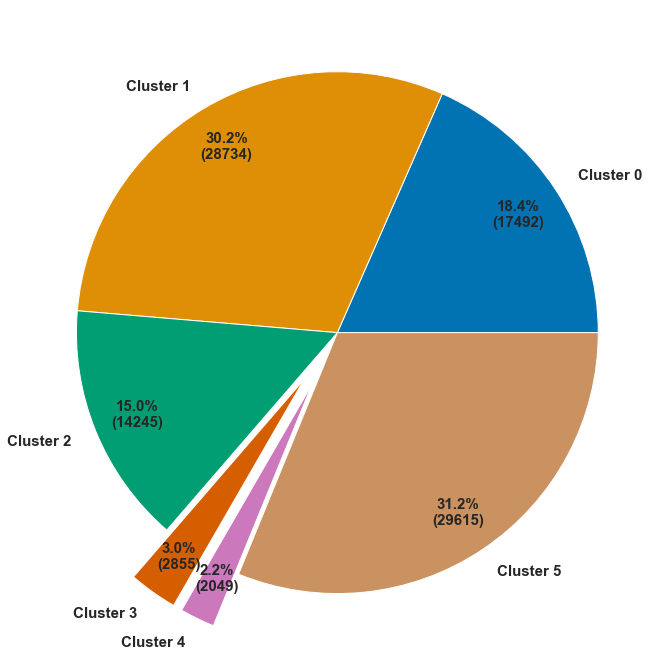

In [35]:
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{:.1f}%\n({v:d})'.format(pct, v=val)
    return my_format


s = df_Customers['Cluster_km'].value_counts()

s = s.sort_index()

plt.figure(figsize=(12, 12))
explode = (0, 0, 0, 0.22, 0.22, 0)

plt.pie(s, labels='Cluster ' + s.index.astype(str), autopct=autopct_format(s), explode=explode,
        colors=color_pal, pctdistance=0.83, labeldistance=1.1, textprops={'fontsize': 15, 'weight': "bold"})

plt.show()

### D) Visualisation par ACP

In [36]:
from sklearn.decomposition import PCA

# Préparation de l'ACP
modelPCA = PCA(n_components=len([*features+log_features]))

# Transformation des données par l'ACP
X_reduced = modelPCA.fit_transform(X_scaled)

# Transformation des coordonnées des centroids par l'ACP
# centro_r = modelPCA.transform(centroids.drop(columns='index'))
print(modelPCA.explained_variance_ratio_)
print(modelPCA.explained_variance_ratio_.cumsum())

[0.23825227 0.20435182 0.1655315  0.15242745 0.13540452 0.10403244]
[0.23825227 0.44260409 0.60813559 0.76056304 0.89596756 1.        ]


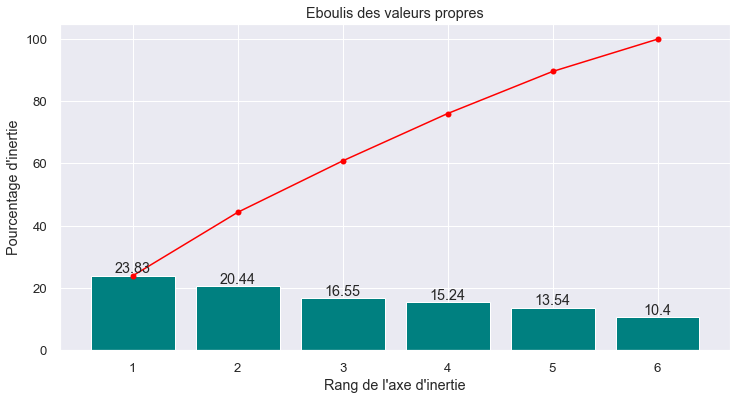

In [37]:
# Représentation des éboulis des valeurs propres afin de voir le pourcentage d'inertie ( variance expliquée) des différents axes de l'ACP
x_list = range(1, len([*features+log_features])+1)
list(x_list)

sns.set(font_scale=1.2)

fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(x_list, (modelPCA.explained_variance_ratio_ *
              100).round(2), color='teal')
plt.plot(x_list, np.cumsum(modelPCA.explained_variance_ratio_)
         * 100, c="red", marker='o')

ax.bar_label(bars)
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show()

In [38]:
# Fonction de représentation graphique des Cercles des corrélations
def correlation_graph(pca,
                      x_y,
                      features):
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y
    x, y = x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0, 0,
                 pca.components_[x, i],
                 pca.components_[y, i],
                 head_width=0.07,
                 head_length=0.07,
                 width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                 pca.components_[y, i] + 0.05,
                 features[i])

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(
        x+1, round(100*pca.explained_variance_ratio_[x], 1)))
    plt.ylabel('F{} ({}%)'.format(
        y+1, round(100*pca.explained_variance_ratio_[y], 1)))

    # Affichage du titre du graphique
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

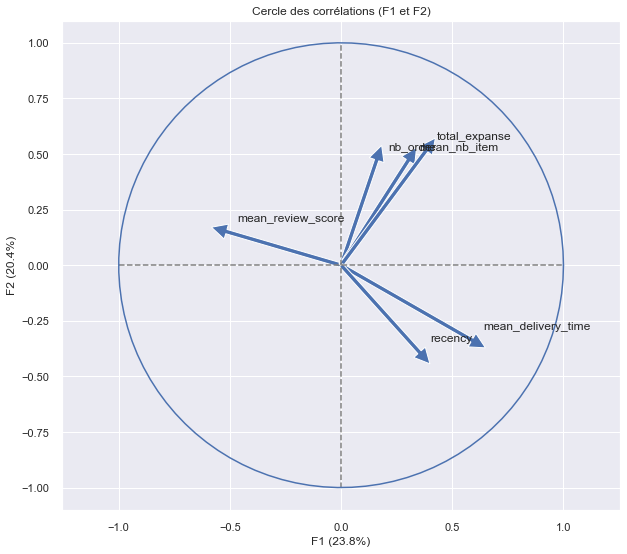

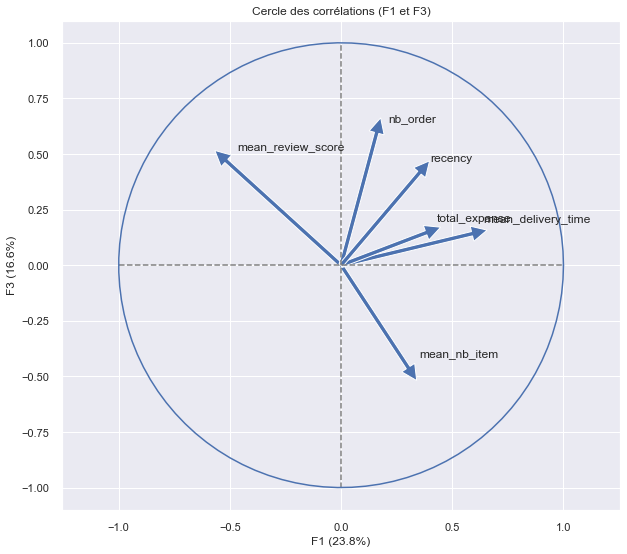

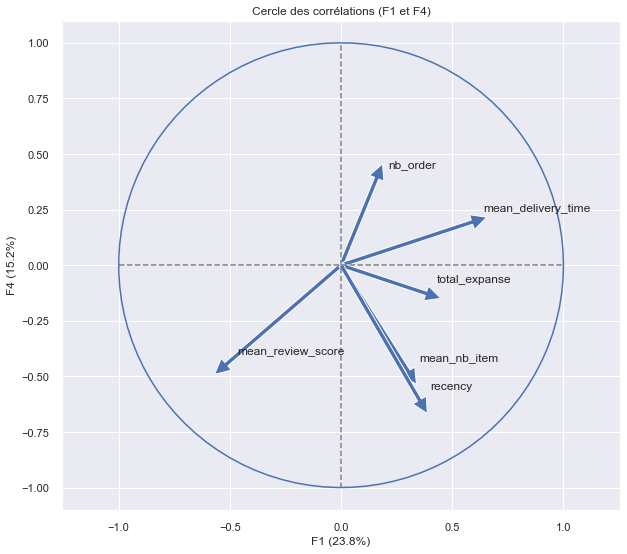

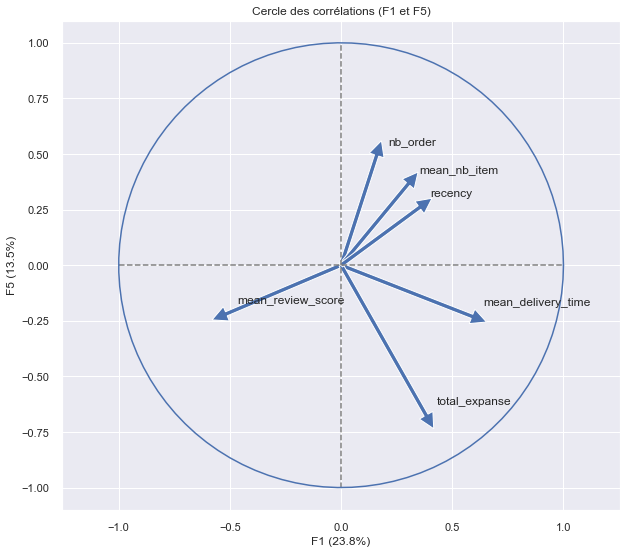

In [39]:
sns.set(font_scale=1)
for i in range(1, 5):
    correlation_graph(modelPCA, (0, i), [*features+log_features])

In [40]:
centroids_km_r = modelPCA.transform(centroids_km.drop(columns="index"))

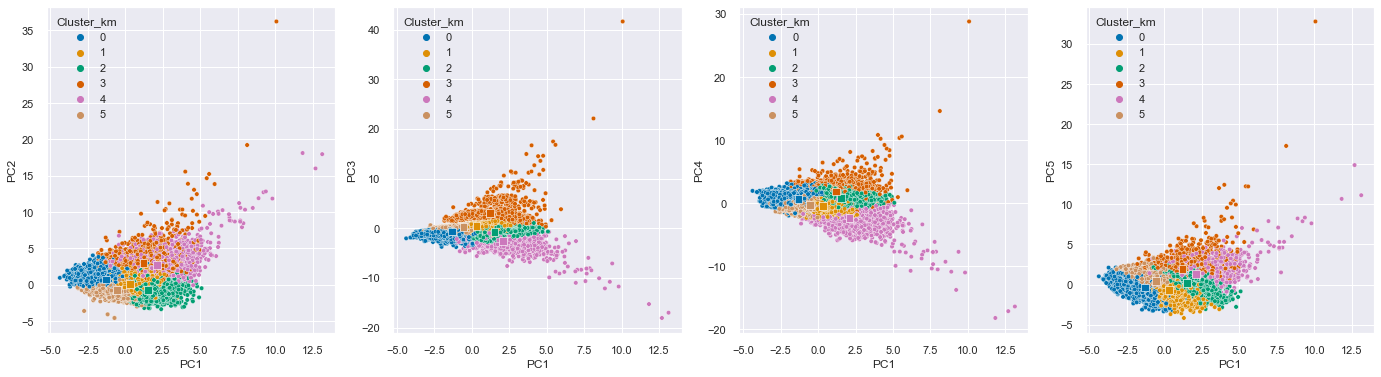

In [41]:
plt.figure(figsize=(30, 6))

for i in range(1, 5):
    ax = plt.subplot(1, 5, i)
    sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, i], alpha=1,
                    s=20, hue=df_Customers['Cluster_km'], palette=color_pal)
    sns.scatterplot(x=centroids_km_r[:, 0], y=centroids_km_r[:, i], alpha=1, s=60,
                    hue=centroids_km['index'], palette=color_pal, marker="s", legend=False)
    plt.xlabel('PC' + str(1))
    plt.ylabel('PC' + str(i+1))

### E) Visualisation par Tsne

In [42]:
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, learning_rate='auto',
                     init='pca', n_jobs=-1)
X_trans = tsne.fit_transform(X_scaled)

C:\Users\ClementD\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


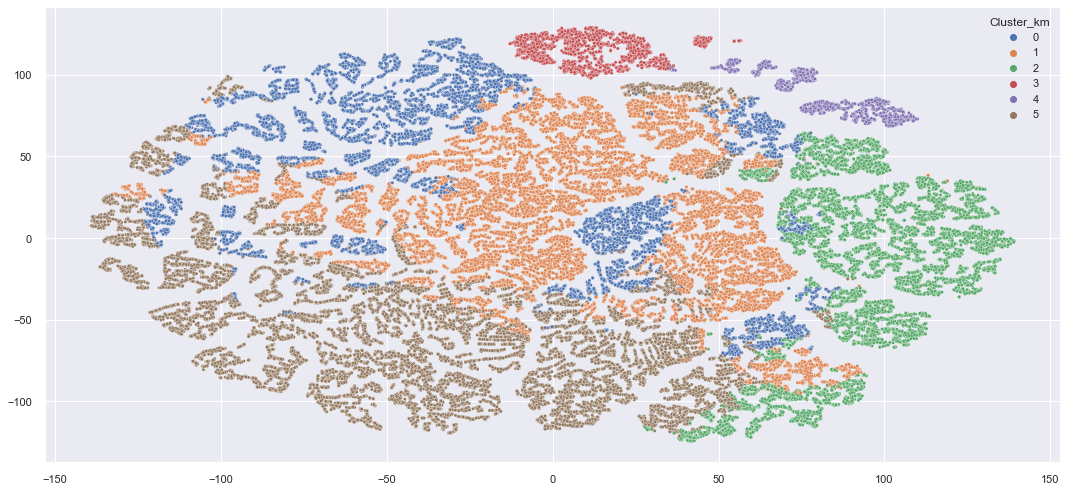

In [43]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(15, 7))
sns.scatterplot(x=X_trans[:, 0], y=X_trans[:, 1], s=10,
                hue=df_Customers['Cluster_km'], palette="deep")

plt.tight_layout()
plt.show()

In [44]:
tsne = manifold.TSNE(n_components=2, learning_rate='auto',
                     init='pca', n_jobs=-1, perplexity=5)
X_trans = tsne.fit_transform(X_scaled)

C:\Users\ClementD\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


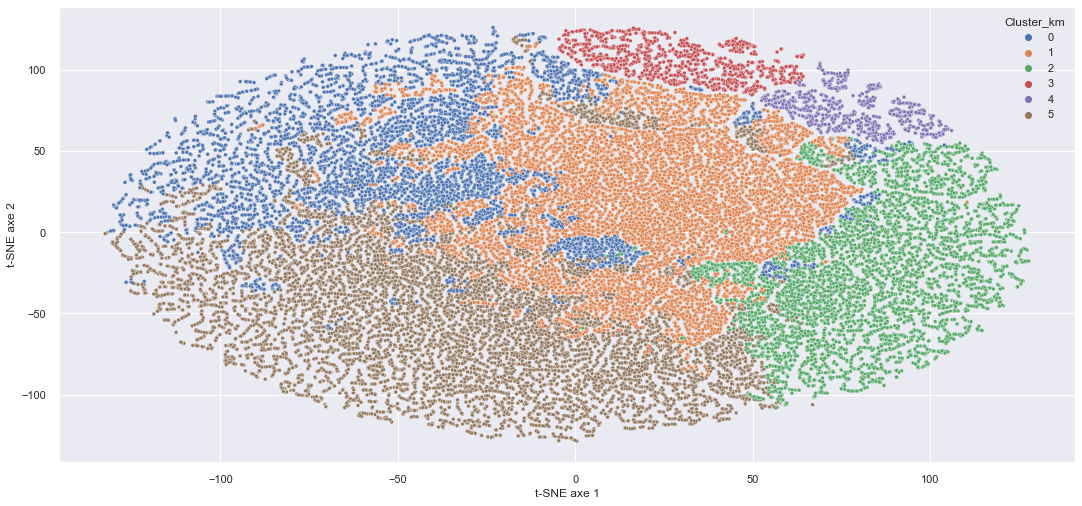

In [45]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(15, 7))
sns.scatterplot(x=X_trans[:, 0], y=X_trans[:, 1], s=12,
                hue=df_Customers['Cluster_km'], palette="deep")

plt.tight_layout()
plt.xlabel('t-SNE axe 1')
plt.ylabel('t-SNE axe 2')
plt.show()